# Lab 2: Classification

### Machine Learning 1, September 2016

* The lab exercises should be made in groups of two people.
* The deadline is October 9th (Sunday) 23:59.
* Assignment should be sent to your teaching assistant. The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* For this notebook you need to answer a few theory questions, add them in the Markdown cell's below the question. Note: you can use Latex-style code in here.
* Focus on Part 1 the first week, and Part 2 the second week!
* You should write your code and answers below the questions in this IPython Notebook.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* If you have questions outside of the labs, post them on blackboard or email me.
* NOTE: Make sure we can run your notebook / scripts!

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [43]:
%pylab inline
import gzip, cPickle
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


In [44]:
def rmse(prd,t):
    """ 
    INPUT: prd is prediction and t is target 
    OUTPUT: error
    This function calculates the root mean squared error between predictions and target values
    """
    rms = np.sqrt(mean_squared_error(t, prd))
    return rms

def softmax(z):
    ''' Compute softmax , implementing with the log-sum-exp trick'''
    return np.exp(z-np.max(z))/np.sum(np.exp(z-np.max(z)))


def sigmoid(z):
    ''' Sigmoid function (without logsumexp)'''
    return 1/(1+np.exp(-z))

def dwsigmoid(z):
    ''' 1st order derivative of the sigmoid '''
    return sigmoid(z)*(1-sigmoid(z))

def cost(inpt,outpt,w,b):
    s = calculate_log_q(inpt, outpt, w, b)
    cost = outpt*np.log(s)+(1-outpt)*np.log(1-s)
        
    return cost


def calculate_log_q(inpt,w,b):
    ''' Sigmoid dot product calculation'''
    a = np.dot(inpt,w) + b.T
    log_q = sigmoid(a)
       
    return a


def calculate_z(log_q):
    z = np.sum(exp(log_q))
        
    return z

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can load the data from `mnist.pkl.gz` we provided, using: 

In [45]:
def load_mnist():
    f = gzip.open('mnist.pkl.gz', 'rb')
    data = cPickle.load(f)
    f.close()
    return data

(x_train, t_train), (x_valid, t_valid), (x_test, t_test) = load_mnist()

idx = np.arange(0,x_train.shape[0])
np.random.shuffle(idx)

#x_shuffle = np.concatenate((np.ones((x_train.shape[0],1)),x_train),axis=1)
x_shuffle = x_train[idx]
t_shuffle = t_train[idx]


The tuples represent train, validation and test sets. The first element (`x_train`, `x_valid`, `x_test`) of each tuple is a $N \times M$ matrix, where $N$ is the number of datapoints and $M = 28^2 = 784$ is the dimensionality of the data. The second element (`t_train`, `t_valid`, `t_test`) of each tuple is the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

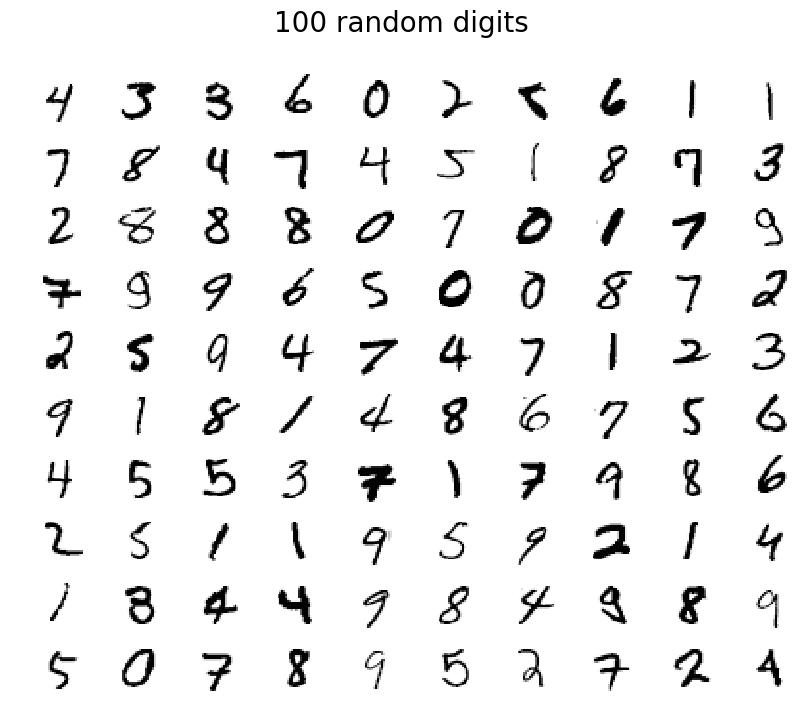

In [46]:
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    pylab.rcParams['figure.figsize'] = (10, 8)
    numrows = int(numdigits/numcols)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, i+1)
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.suptitle("%u random digits"%(numdigits),fontsize=20)
    plt.show()
    
    
plot_digits(x_shuffle[0:100,:], numcols=10)

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_j \exp(\log q_j)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

Warning: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization

### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

#####Answer: 

[insert answer in this cell]

### 1.1.2 Implement gradient computations (10 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).


In [47]:
def predict(x,w,b):
    """Compute log q (unnormalized probabilities)"""

    
    """ Perform softmax to normalize """
    loglikelihood = softmax(x.dot(w)+b.T)
    
    #print "loglikelihood shape: ", loglikelihood.shape, "\nvalues: ", loglikelihood
    
    """ Predict """
    #print loglikelihood.shape
    prediction = np.argmax(loglikelihood, axis = 1)
    #print "predictions: ", prediction
    #print prediction
    return prediction
    

In [48]:
def logreg_gradient(x,t,w,b):
    N = x.shape[0]
    dw = np.zeros((w.shape))
   
    """Compute gradient w.r.t b"""
    db = 1/N * np.sum(x.dot(x.T)) 
    
    """Compute log q (unnormalized probabilities)"""
    log_q = calculate_log_q(x,w,b)
    #print "log_q shape: ", log_q.shape#, "\nvalues: ", log_q

    """ Compute gradients """
    dw = compute_grad(log_q, x, t, w)      # w or dw ???
    #print "dw shape", dw.shape
    
    return dw, db

def compute_grad(log_q, X, t, w):
    
    #print "true class: ", y
    grad = np.zeros(w.shape)
    new_t = np.zeros(log_q.shape)
    
    #new_t[0][t] = 1 
    #print "target vector", new_t
    
    delta = log_q - t
    l = grad.shape[0]
    #print 'delta = ', delta
    
    #print "size delta: ", delta.shape
    #print "size of grad: ", grad.shape
    #print "size of x: ", X.shape

    for i in range(l):
        sumdelta = delta.T.dot(X[i])
        #print "sumdelta shape: ", sumdelta.shape           
        #grad[i] = (1.0 / X.size) * sumdelta[0] * - 1
        #grad[i] = sumdelta[0] X * -1
    #print sumdelta    
    return grad



""" function to compute the gradient of parameters for a single data sample """
def compute_gradients(self,out,y,x):
    out=(np.reshape(out,(np.shape(out)[0],1)));
    out[y]=out[y]-1;
    W=out*x.T;
    res=np.vstack((W.T,out.flatten()))
    return res;

''' function to compute the gradient of loss function over all input samples'''
""" function to compute the gradient of loss function over all input samples
    params is optional input parameter passed to the classifier,which is useful in cases
    of iterative optimization routines,added for compatiblity with
    scipi.optimization package """
def gradients(self,params=None):
    # args contains the training data
    x,y=self.args;
    self.update_params(params);
    sigmoid_activation = pyvision.softmax(self.W,self.b,x);
    e = [ self.compute_gradients(a,c,b) for a, c,b in izip(sigmoid_activation,y,x)]
    mean1=np.mean(e,axis=0);
    mean1=mean1.T.flatten();
    return mean1;


########### 
img_shape = (28,28)
sigma = 0.1
num_classes = np.max(t_train)+1
num_dims = x_train.shape[1]
#print "dimensions", num_dims

# INITIALIZE RANDOM 
b = np.random.normal(0,np.ones(num_classes)*0.1)
b = np.reshape(b,(-1,1))
w = np.random.normal(0,np.ones((num_dims,num_classes))*0.1)
#print "weights shape: ", w.shape
#print "bias.shape", b.shape


# TEST FUNCTION
#dw, db = logreg_gradient(x_train[0],t_train[0],w,b)  




### 1.1.3 Stochastic gradient descent (10 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters using a small learning rate (e.g. `1E-4`). Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [50]:
def sgd_iter(x_train, t_train, w, b,eta):
    """Get old weights"""
    w_old = w
    
    """Iterate through all x_train"""
    for i in range(100):
        dw, db = logreg_gradient(x_train[i],t_train[i],w_old,b)
        
        """Calculate new weight"""
        new_w = w_old + eta * dw 
        
        """Set old = new"""
        w_old = new_w
    
    #print w.shape
    #print dw.shape
    #print new_w.shape
    
    return new_w, db

#print x_shuffle.shape
#print t_shuffle.shape

maxiter = 10
rmse_error = np.zeros(100)
eta = 10**-2
ypreds = np.zeros(x_shuffle.shape[0])
for i in range(maxiter):
    
    ypreds = predict(x_shuffle,w,b)
    w, b = sgd_iter(x_shuffle, t_shuffle, w, b,eta)
    
    #print ypreds.shape
    rmse_error[i] = rmse(ypreds,t_shuffle)
    print "rmse error:",rmse_error[i]
    
    print "iteration: ", i , " eta: ",eta
    
    



iteration:  0  eta:  0.01  rmse error: 3.49186196749
iteration:  1  eta:  0.01  rmse error: 3.49186196749
iteration:  2  eta:  0.01  rmse error: 3.49186196749
iteration:  3  eta:  0.01  rmse error: 3.49186196749
iteration:  4  eta:  0.01  rmse error: 3.49186196749
iteration:  5  eta:  0.01  rmse error: 3.49186196749
iteration:  6  eta:  0.01  rmse error: 3.49186196749
iteration:  7  eta:  0.01  rmse error: 3.49186196749
iteration:  8  eta:  0.01  rmse error: 3.49186196749
iteration:  9  eta:  0.01  rmse error: 3.49186196749


## 1.2. Train

### 1.2.1 Train (10 points)
Perform a handful of training iterations through the trainingset. Plot (in one graph) the conditional log-probability of the trainingset and validation set after each iteration.


### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.
Ask yourself if these results make sense.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron wil have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$.

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

#####Answer: 

[insert answer in this Markdown cell]

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

#####Answer: 

[insert answer in this Markdown cell]

## 2.3. Implement and train a MLP (15 points)

Implement a MLP model with a single hidden layer, and code to train the model.

### 2.3.1. Less than 250 misclassifications on the test set (10 bonus points)

You receive an additional 10 bonus points if you manage to train a model with very high accuracy: at most 2.5% misclasified digits on the test set. Note that the test set contains 10000 digits, so you model should misclassify at most 250 digits. This should be achievable with a MLP model with one hidden layer. See results of various models at : `http://yann.lecun.com/exdb/mnist/index.html`. To reach such a low accuracy, you probably need to have a very high $L$ (many hidden units), probably $L > 200$, and apply a strong Gaussian prior on the weights. In this case you are allowed to use the validation set for training.
You are allowed to add additional layers, and use convolutional networks, although that is probably not required to reach 2.5% misclassifications.